In [1]:
!pip install tensorflow 

     |████████████████████████████████| 462 kB 5.0 MB/s 


In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import json
import pickle


In [3]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import SGD
import random

In [4]:
import nltk
nltk.download('punkt')
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [5]:
words=[]
classes = []
documents = []
ignore_words = ['?', '!']

with open('intents_2.json') as json_data:
    intents = json.load(json_data)


In [6]:
for intent in intents['intents']:
    for pattern in intent['patterns']:

        #tokenize each word
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        #add documents in the corpus
        documents.append((w, intent['tag']))

        # add to our classes list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

In [7]:
print(len(words),len(classes),len(documents))

8350 246 810


In [8]:
# import pandas as pd
# data=pd.DataFrame({'docs':documents})
# data.to_csv('docs.csv',index=False)

In [9]:
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]
words = sorted(list(set(words)))
# sort classes
# classes = sorted(list(set(classes)))
# documents = combination between patterns and intents
print (len(documents), "documents")
# classes = intents
print (len(classes), "classes", classes)
# words = all words, vocabulary
print (len(words), "unique lemmatized words", words)


pickle.dump(words,open('words.pkl','wb'))
pickle.dump(classes,open('classes.pkl','wb'))

810 documents
246 classes [['greetings'], ['bye'], ['creator'], ['age'], ['functions'], ['Cuts'], ['Abrasions'], ['stings'], ['Splinter'], 'Sprains', ['Strains'], ['Fever'], ['Nasal Congestion'], ['Cough'], ['Sore Throat'], ['Gastrointestinal problems'], ['Skin problems'], ['Abdonominal Pain'], ['Bruises'], 'Broken Toe', ['Choking'], 'Wound', ['Diarrhea'], ['Frost bite'], ['Heat Exhaustion'], ['Heat Stroke'], ['Insect Bites'], ['nose bleed'], 'Pulled Muscle', ['Rectal bleeding'], ['Sun Burn'], ['Testicle Pain'], ['Vertigo'], ['Normal Bleeding'], ['Eye Injury'], ['Chemical Burn'], ['Poison'], ['Teeth'], 'seizure', ['Head Injury'], ['Fainting'], 'Headache', ['Cold'], ['Rash'], 'snake bite', ['animal bite'], ['Drowning'], ['CPR'], ['Fracture'], ['disease1'], ['disease2'], ['disease3'], ['disease4'], ['disease5'], ['disease6'], ['disease7'], ['disease8'], ['disease9'], ['disease10'], ['disease11'], ['disease12'], ['disease13'], ['disease14'], ['disease15'], ['disease16'], ['disease17'], ['

In [10]:

# create our training data
training = []
# create an empty array for our output
output_empty = [0] * len(classes)
# training set, bag of words for each sentence
for doc in documents:
    # initialize our bag of words
    bag = []
    # list of tokenized words for the pattern
    pattern_words = doc[0]
    # lemmatize each word - create base word, in attempt to represent related words
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in pattern_words]
    # create our bag of words array with 1, if word match found in current pattern
    for w in words:
        bag.append(1) if w in pattern_words else bag.append(0)
    
    # output is a '0' for each tag and '1' for current tag (for each pattern)
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    
    training.append([bag, output_row])
# shuffle our features and turn into np.array
random.shuffle(training)
training = np.array(training)
# create train and test lists. X - patterns, Y - intents
train_x = list(training[:,0])
train_y = list(training[:,1])
print("Training data created")


Training data created


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(np.array(train_x), np.array(train_y), test_size=0.15)

In [20]:
# Create model - 3 layers. First layer 128 neurons, second layer 64 neurons and 3rd output layer contains number of neurons
# equal to number of intents to predict output intent with softmax
model = Sequential()
model.add(Dense(256, input_shape=(len(X_train[0]),), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(len(Y_train[0]), activation='softmax'))

model.summary()
# Compile model. Stochastic gradient descent with Nesterov accelerated gradient gives good results for this model
sgd = SGD(lr=0.01, decay=1e-4, momentum=0.8, nesterov=True)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               225536    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 246)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [21]:
####epochs
no_epochs=200
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [22]:
from keras.callbacks import History
history = History()
m = model.fit(X_train, Y_train, validation_data = (X_test, Y_test),
                   epochs = 100, batch_size = 5, callbacks = [history])   

Epoch 1/100
138/138 [==============================] - 1s 5ms/step - loss: 5.5001 - accuracy: 0.0145 - val_loss: 5.4882 - val_accuracy: 0.0328
Epoch 2/100
138/138 [==============================] - 0s 4ms/step - loss: 5.4652 - accuracy: 0.0305 - val_loss: 5.4660 - val_accuracy: 0.0328
Epoch 3/100
138/138 [==============================] - 1s 4ms/step - loss: 5.4155 - accuracy: 0.0291 - val_loss: 5.4380 - val_accuracy: 0.0328
Epoch 4/100
138/138 [==============================] - 1s 4ms/step - loss: 5.3538 - accuracy: 0.0392 - val_loss: 5.4020 - val_accuracy: 0.0164
Epoch 5/100
138/138 [==============================] - 1s 4ms/step - loss: 5.2427 - accuracy: 0.0392 - val_loss: 5.3594 - val_accuracy: 0.0164
Epoch 6/100
138/138 [==============================] - 0s 3ms/step - loss: 5.0743 - accuracy: 0.0523 - val_loss: 5.2767 - val_accuracy: 0.0492
Epoch 7/100
138/138 [==============================] - 0s 4ms/step - loss: 4.8731 - accuracy: 0.0741 - val_loss: 5.1694 - val_accuracy: 0.0246

In [23]:
import matplotlib.pyplot as plt 

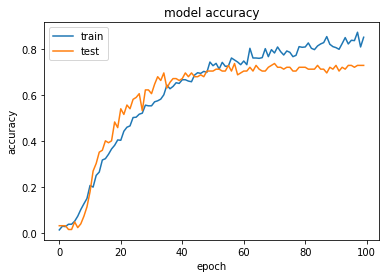

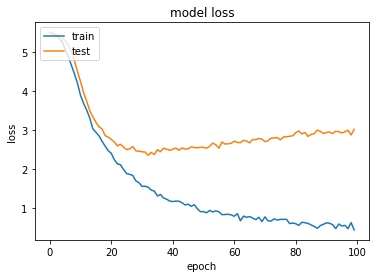

In [25]:
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [17]:
model.save('chatbot_model.h5')
print("model created")

model created
